In [1]:
%load_ext autoreload
%autoreload 2

import datetime
import numpy as np
import scipy as sp
import pandas as pd
import functools as fts
import multiprocessing as mp
from tqdm.notebook import tqdm
from tqdm.contrib import tzip, tenumerate, tmap

from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.storagelevel import StorageLevel
from pyspark.sql.functions import col
import pyspark.sql.types as pstype
import pyspark.sql.functions as F
import pyspark as ps

import matplotlib as mlt
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML
import japanize_matplotlib

from time_series_model import *

%matplotlib inline
%matplotlib ipympl

In [2]:
np.set_printoptions(threshold=100, precision=4, linewidth=10000)
ps_conf = ps.SparkConf().set("spark.logConf", "false")\
            .set("spark.executor.memory", "12g")\
            .set("spark.driver.memory", "4g")\
            .set("spark.executor.cores", "7")\
            .set("spark.sql.shuffle.partitions", "500")\
            .set("spark.executor.extraJavaOptions", "-XX:+UseG1GC -XX:+UseStringDeduplication")\
            .set("spark.eventLog.gcMetrics.youngGenerationGarbageCollectors", "G1 Young Generation")\
            .set("spark.eventLog.gcMetrics.oldGenerationGarbageCollectors", "G1 Old Generation")\
			.set("spark.logConf", "false")
spark = SparkSession.builder.config(conf=ps_conf).getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/21 15:05:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/10/21 15:05:17 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
SPECIFIED_PATH = "csv_data/"
SPECIFIED_DATE = "20240918"
SPECIFIED_CSV  = SPECIFIED_PATH + SPECIFIED_DATE

In [4]:
input_path = SPECIFIED_CSV + "_c-united_config.csv"
df_config  = spark.read.option("inferSchema", "True").option("header", "True").csv(input_path)
df_config.persist(StorageLevel.MEMORY_AND_DISK_DESER)

utid_list = df_config.select("unit_id").drop_duplicates().rdd.flatMap(lambda x: x).collect()
spid_list = df_config.select("shop_id").drop_duplicates().rdd.flatMap(lambda x: x).collect()

In [5]:
#pos data 前処理
input_path  = SPECIFIED_CSV + "_pos_data_table.csv"
df_pos_data = spark.read.option('inferSchema', 'True').option('header', 'True').csv(input_path)\
				.select(
					"shop_id",
                    "レシートＮｏ．",
                    "商品種別",
                    "商品コード",
                    F.regexp_replace(col("商品名称（または券名称）"), "[ 　]", "").alias("商品名称（または券名称）"),
                    "オーダー時刻",
                    "単価",
                    "数量",
                    "合計金額",
                    "date"
				)\
				.filter(col("商品名称（または券名称）") != "")\
				.groupBy("shop_id", "date", "レシートＮｏ．").agg(
                    F.last("オーダー時刻").alias("オーダー時刻"),
                    F.sum(F.when(col("商品種別") == "Y", 1).otherwise(0)).alias("レシートあたりのセット商品の数"),
                    F.sum("数量").alias("総売上点数"),
                    F.sum("合計金額").alias("総売上"),
				)\
                .withColumn("レシートあたりのセット商品の数", F.when(col("レシートあたりのセット商品の数") == 0, 1)
                            								.otherwise(col("レシートあたりのセット商品の数")))\
                .withColumn("オーダー時刻", (F.col("オーダー時刻") / 100).cast("int"))\
                .withColumnRenamed("レシートあたりのセット商品の数", "来店者数")\
                .withColumnRenamed("オーダー時刻", "hour")
df_pos_data = df_pos_data.groupBy("shop_id", "date", "hour").agg(
                    F.sum("来店者数").alias("来店者数"),
                    F.sum("総売上点数").alias("総売上点数"),
                    F.sum("総売上").alias("総売上"),
				)\
                .select(["shop_id", "date", "hour", "来店者数", "総売上点数", "総売上"])\
                .orderBy(col("shop_id").asc(), col("date").asc(), col("hour").asc())
df_pos_data.show()

+-------+----------+----+--------+----------+------+
|shop_id|      date|hour|来店者数|総売上点数|総売上|
+-------+----------+----+--------+----------+------+
|   1189|2023-10-10|   6|       1|         1|   360|
|   1189|2023-10-10|   7|      56|        98| 43340|
|   1189|2023-10-10|   8|      50|        84| 36170|
|   1189|2023-10-10|   9|      66|       404|156520|
|   1189|2023-10-10|  10|      62|       129| 57640|
|   1189|2023-10-10|  11|      52|       120| 66465|
|   1189|2023-10-10|  12|     107|       206| 99340|
|   1189|2023-10-10|  13|      97|       166| 76190|
|   1189|2023-10-10|  14|      92|       185| 90990|
|   1189|2023-10-10|  15|     102|       176| 77170|
|   1189|2023-10-10|  16|     102|       204| 90260|
|   1189|2023-10-10|  17|      69|       174| 80205|
|   1189|2023-10-10|  18|      77|       125| 60590|
|   1189|2023-10-10|  19|      67|       133| 61540|
|   1189|2023-10-10|  20|      41|        74| 34710|
|   1189|2023-10-10|  21|      13|        26| 11895|
|   1

In [6]:
df_pos_data = df_pos_data\
    				.withColumn("date", F.from_unixtime(F.unix_timestamp("date") + F.col("hour") * 3600))\
                    .drop("hour")\
                    .orderBy(col("shop_id").asc(), col("date").asc())
df_pos_data.show()

+-------+-------------------+--------+----------+------+
|shop_id|               date|来店者数|総売上点数|総売上|
+-------+-------------------+--------+----------+------+
|   1189|2023-10-10 06:00:00|       1|         1|   360|
|   1189|2023-10-10 07:00:00|      56|        98| 43340|
|   1189|2023-10-10 08:00:00|      50|        84| 36170|
|   1189|2023-10-10 09:00:00|      66|       404|156520|
|   1189|2023-10-10 10:00:00|      62|       129| 57640|
|   1189|2023-10-10 11:00:00|      52|       120| 66465|
|   1189|2023-10-10 12:00:00|     107|       206| 99340|
|   1189|2023-10-10 13:00:00|      97|       166| 76190|
|   1189|2023-10-10 14:00:00|      92|       185| 90990|
|   1189|2023-10-10 15:00:00|     102|       176| 77170|
|   1189|2023-10-10 16:00:00|     102|       204| 90260|
|   1189|2023-10-10 17:00:00|      69|       174| 80205|
|   1189|2023-10-10 18:00:00|      77|       125| 60590|
|   1189|2023-10-10 19:00:00|      67|       133| 61540|
|   1189|2023-10-10 20:00:00|      41|     

In [7]:
df_pos_data = df_pos_data\
					.join(df_config.select(["shop_id", "caption"]), on="shop_id", how="inner")\
                    .select(["shop_id", "caption", "date", "来店者数", "総売上点数", "総売上"])\
                    .orderBy(col("shop_id").asc(), col("date").asc())
df_pos_data.show()

+-------+-------------------------------------+-------------------+--------+----------+------+
|shop_id|                              caption|               date|来店者数|総売上点数|総売上|
+-------+-------------------------------------+-------------------+--------+----------+------+
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 06:00:00|       1|         1|   360|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 07:00:00|      56|        98| 43340|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 08:00:00|      50|        84| 36170|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 09:00:00|      66|       404|156520|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 10:00:00|      62|       129| 57640|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 11:00:00|      52|       120| 66465|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 12:00:00|     107|       206| 99340|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 13:00:00|      97|       166| 76190|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 14:00:00|      92|       185| 90990|
|   1189|カフェ・ド・クリエグランサンシャ

In [8]:
pd_pos_data  = df_pos_data.select(["shop_id", "caption", "date", "来店者数"]).toPandas()
pd_tmp_data1 = pd_pos_data[pd_pos_data["shop_id"] == 1189] # カフェ・ド・クリエグランサンシャイン通り店
pd_tmp_data2 = pd_pos_data[pd_pos_data["shop_id"] == 1616] # カフェ・ド・クリエ日比谷通り内幸町店
pd_tmp_data3 = pd_pos_data[pd_pos_data["shop_id"] == 1428] # カフェ・ド・クリエ札幌オーロラタウン店
pd_tmp_data4 = pd_pos_data[pd_pos_data["shop_id"] == 1550] # カフェ・ド・クリエ博多大博通店
pd_pos_data  = pd.merge(pd_tmp_data1, pd_tmp_data2, on="date", how="inner", suffixes=['_1', '_2'])
pd_pos_data  = pd.merge(pd_pos_data,  pd_tmp_data3, on="date", how="inner", suffixes=['_2', '_3'])
pd_pos_data  = pd.merge(pd_pos_data,  pd_tmp_data4, on="date", how="inner", suffixes=['_3', '_4'])
pd_pos_data  = pd_pos_data[["date", "来店者数_1", "来店者数_2", "来店者数_3", "来店者数_4"]]
pd_pos_data  = pd_pos_data.rename(columns={
    								"来店者数_1": "カフェ・ド・クリエグランサンシャイン通り店",
                                    "来店者数_2": "カフェ・ド・クリエ日比谷通り内幸町店",
                                    "来店者数_3": "カフェ・ド・クリエ札幌オーロラタウン店",
                                    "来店者数_4": "カフェ・ド・クリエ博多大博通店"
                                })
pd_pos_data  = pd_pos_data[[
    				"date",
                    "カフェ・ド・クリエグランサンシャイン通り店",
                    "カフェ・ド・クリエ日比谷通り内幸町店",
                    "カフェ・ド・クリエ札幌オーロラタウン店",
                    "カフェ・ド・クリエ博多大博通店"
                ]]
del pd_tmp_data1
del pd_tmp_data2
del pd_tmp_data3
del pd_tmp_data4
pd_pos_data

24/10/21 15:05:31 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


,date,カフェ・ド・クリエグランサンシャイン通り店,カフェ・ド・クリエ日比谷通り内幸町店,カフェ・ド・クリエ札幌オーロラタウン店,カフェ・ド・クリエ博多大博通店
0,2023-10-10 07:00:00,56,45,14,20
1,2023-10-10 08:00:00,50,45,14,23
2,2023-10-10 09:00:00,66,12,15,26
3,2023-10-10 10:00:00,62,13,15,16
4,2023-10-10 11:00:00,52,45,36,19
...,...,...,...,...,...
3827,2024-09-15 13:00:00,103,18,33,29
3828,2024-09-15 14:00:00,127,10,25,20
3829,2024-09-15 15:00:00,120,23,42,27
3830,2024-09-15 16:00:00,125,16,27,15


In [9]:
x_data = pd_pos_data[["カフェ・ド・クリエグランサンシャイン通り店", "カフェ・ド・クリエ日比谷通り内幸町店", "カフェ・ド・クリエ札幌オーロラタウン店", "カフェ・ド・クリエ博多大博通店"]].values.tolist()
x_train, x_test = x_data[0:3600], x_data[3600:]

{'mean': array([[ 32.9501],
        [ 20.0887],
        [ -1.0318],
        [104.0368]])}

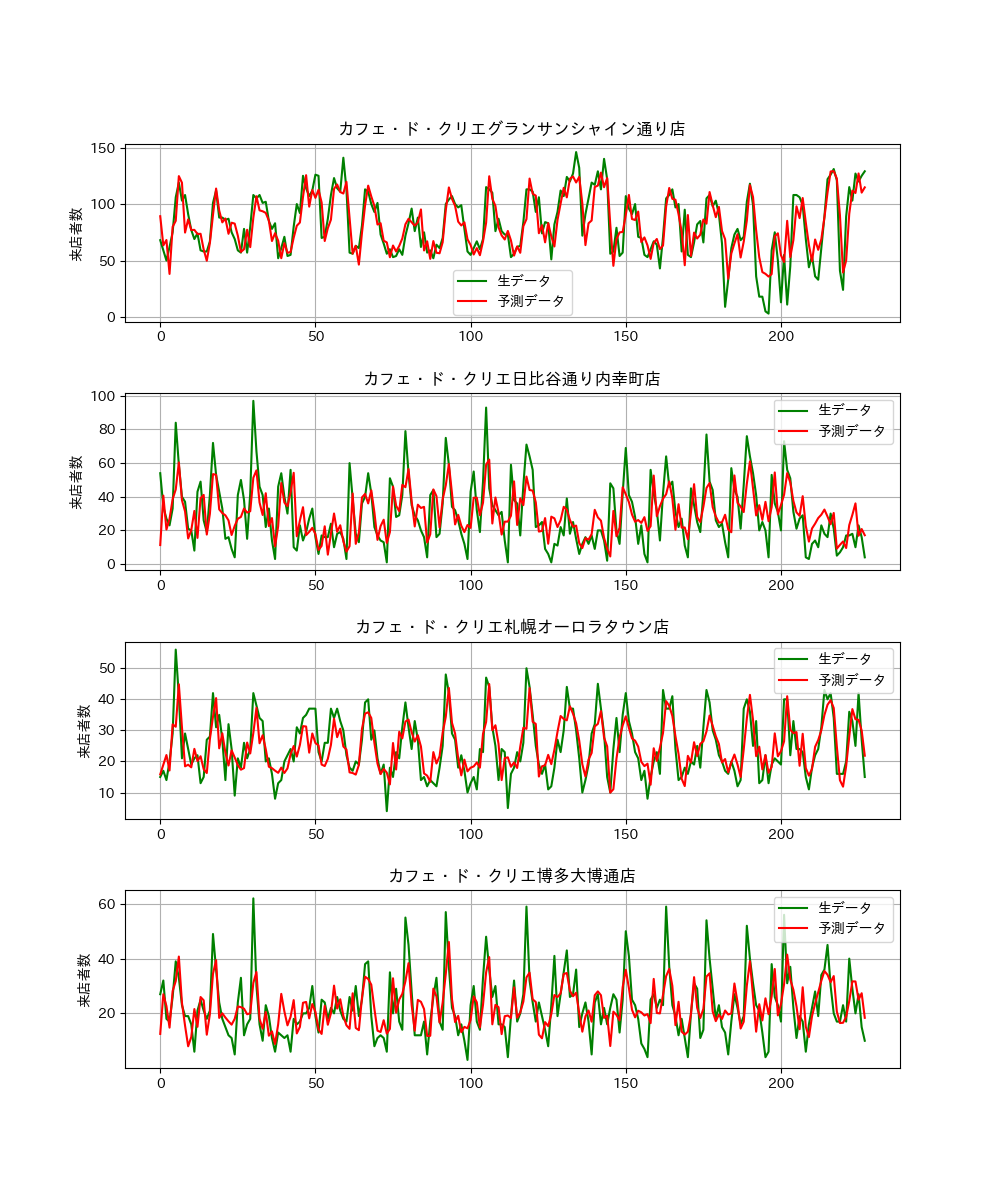

In [10]:
model  = Vector_Auto_Regressive(x_test)

lag = 4
model.fit(lags=lag)

num = len(x_test)
mean = []
for idx in range(lag, num):
	test_data = []
	for idx2 in range(0, lag):
		test_data = test_data + x_test[idx - idx2 - 1]
	tmp = model.predict([test_data])
	mean.append(tmp[0])

x_test, mean = np.array(x_test), np.array(mean)
plt.figure(figsize=(10, 12))
plt.subplots_adjust(wspace=0.15,hspace=0.4)

plt.subplot(4,1,1)
plt.plot(x_test[lag:, 0], "-", color="green", label="生データ")
plt.plot(mean[:, 0],      "-", color="red",   label="予測データ")
plt.title("カフェ・ド・クリエグランサンシャイン通り店")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()

plt.subplot(4,1,2)
plt.plot(x_test[lag:, 1], "-", color="green", label="生データ")
plt.plot(mean[:, 1],      "-", color="red",   label="予測データ")
plt.title("カフェ・ド・クリエ日比谷通り内幸町店")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()

plt.subplot(4,1,3)
plt.plot(x_test[lag:, 2], "-", color="green", label="生データ")
plt.plot(mean[:, 2],      "-", color="red",   label="予測データ")
plt.title("カフェ・ド・クリエ札幌オーロラタウン店")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()

plt.subplot(4,1,4)
plt.plot(x_test[lag:, 3], "-", color="green", label="生データ")
plt.plot(mean[:, 3],      "-", color="red",   label="予測データ")
plt.title("カフェ・ド・クリエ博多大博通店")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()


model.stat_inf()

In [11]:
print(model.stat_inf())
print(model.log_likelihood())
print(model.model_reliability(ic="aic"))
print(model.model_reliability(ic="bic"))
print(model.model_reliability(ic="hqic"))

{'mean': array([[ 32.9501],
       [ 20.0887],
       [ -1.0318],
       [104.0368]])}
-3379.5116699663777
18.88982217266417
19.912609465510233
19.302485908740007


In [12]:
lag = model.select_order(maxlag=20, ic="hqic", isVisible=True)

AR model | hqic
AR(1) | 19.374413374013198
AR(2) | 19.418544758958507
AR(3) | 19.425727260658686
AR(4) | 19.337913578658977
AR(5) | 19.50242225980267
AR(6) | 19.518837535543014
AR(7) | 19.638137745092386
AR(8) | 19.71330436890948
AR(9) | 19.756429489089886
AR(10) | 19.82776405605778
AR(11) | 19.95626766231109
AR(12) | 20.087865096536248
AR(13) | 20.200555503433307
AR(14) | 20.34093544975612
AR(15) | 20.437684998857428
AR(16) | 20.598970254296052
AR(17) | 20.682551032135155
AR(18) | 20.816378587091574
AR(19) | 20.90247630856645
AR(20) | 21.013386281122123
selected orders | 4


{'mean': array([[ 32.9501],
        [ 20.0887],
        [ -1.0318],
        [104.0368]])}

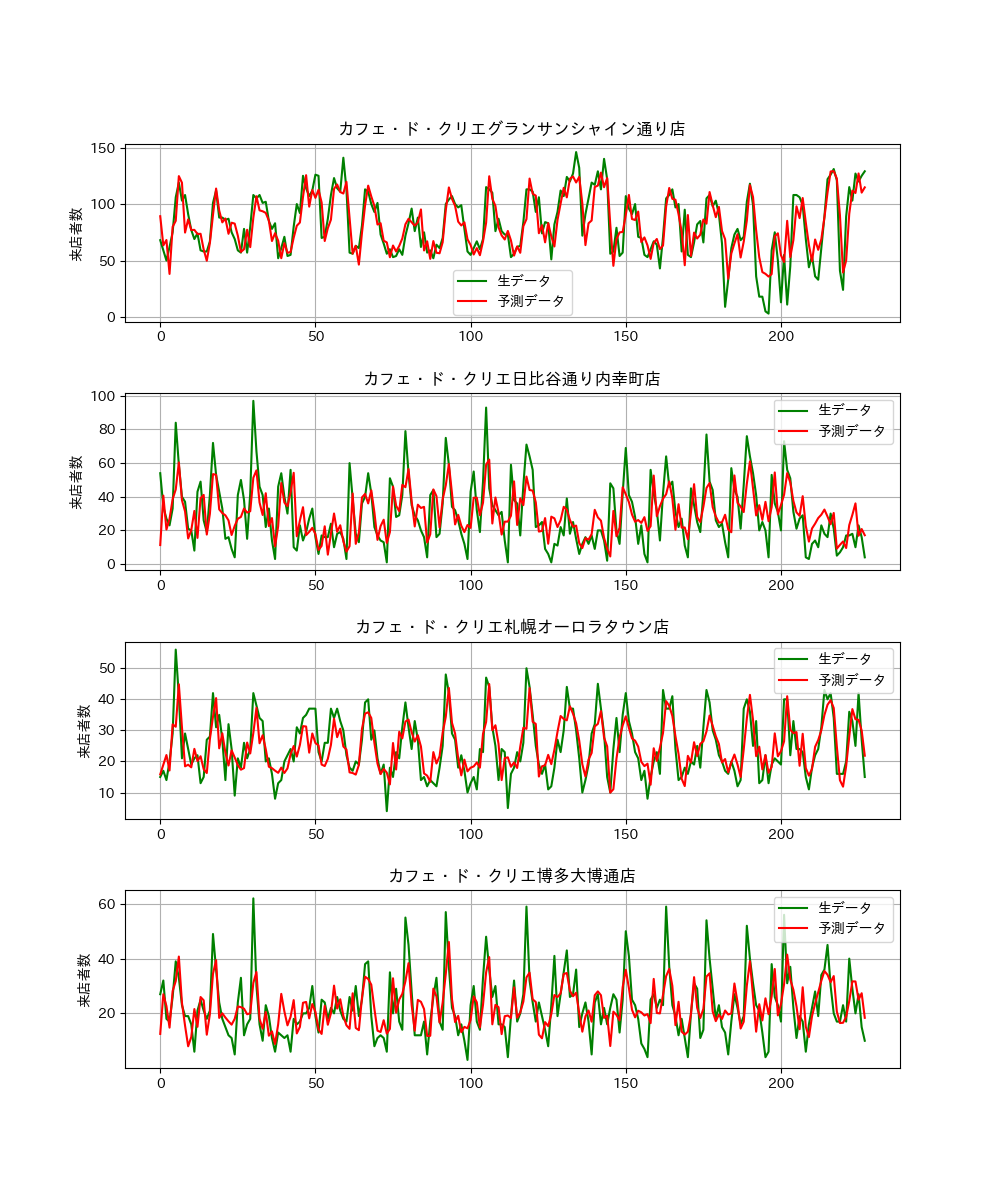

In [13]:
x_train, x_test = x_data[0:3600], x_data[3600:]
num = len(x_test)
mean = []
for idx in range(lag, num):
	test_data = []
	for idx2 in range(0, lag):
		test_data = test_data + x_test[idx - idx2 - 1]
	tmp = model.predict([test_data])
	mean.append(tmp[0])

x_plot, mean = np.array(x_test), np.array(mean)
plt.figure(figsize=(10, 12))
plt.subplots_adjust(wspace=0.15,hspace=0.4)

plt.subplot(4,1,1)
plt.plot(x_plot[lag:, 0], "-", color="green", label="生データ")
plt.plot(mean[:, 0],      "-", color="red",   label="予測データ")
plt.title("カフェ・ド・クリエグランサンシャイン通り店")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()

plt.subplot(4,1,2)
plt.plot(x_plot[lag:, 1], "-", color="green", label="生データ")
plt.plot(mean[:, 1],      "-", color="red",   label="予測データ")
plt.title("カフェ・ド・クリエ日比谷通り内幸町店")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()

plt.subplot(4,1,3)
plt.plot(x_plot[lag:, 2], "-", color="green", label="生データ")
plt.plot(mean[:, 2],      "-", color="red",   label="予測データ")
plt.title("カフェ・ド・クリエ札幌オーロラタウン店")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()

plt.subplot(4,1,4)
plt.plot(x_plot[lag:, 3], "-", color="green", label="生データ")
plt.plot(mean[:, 3],      "-", color="red",   label="予測データ")
plt.title("カフェ・ド・クリエ博多大博通店")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()


model.stat_inf()

{'mean': array([[ 32.9501],
        [ 20.0887],
        [ -1.0318],
        [104.0368]])}

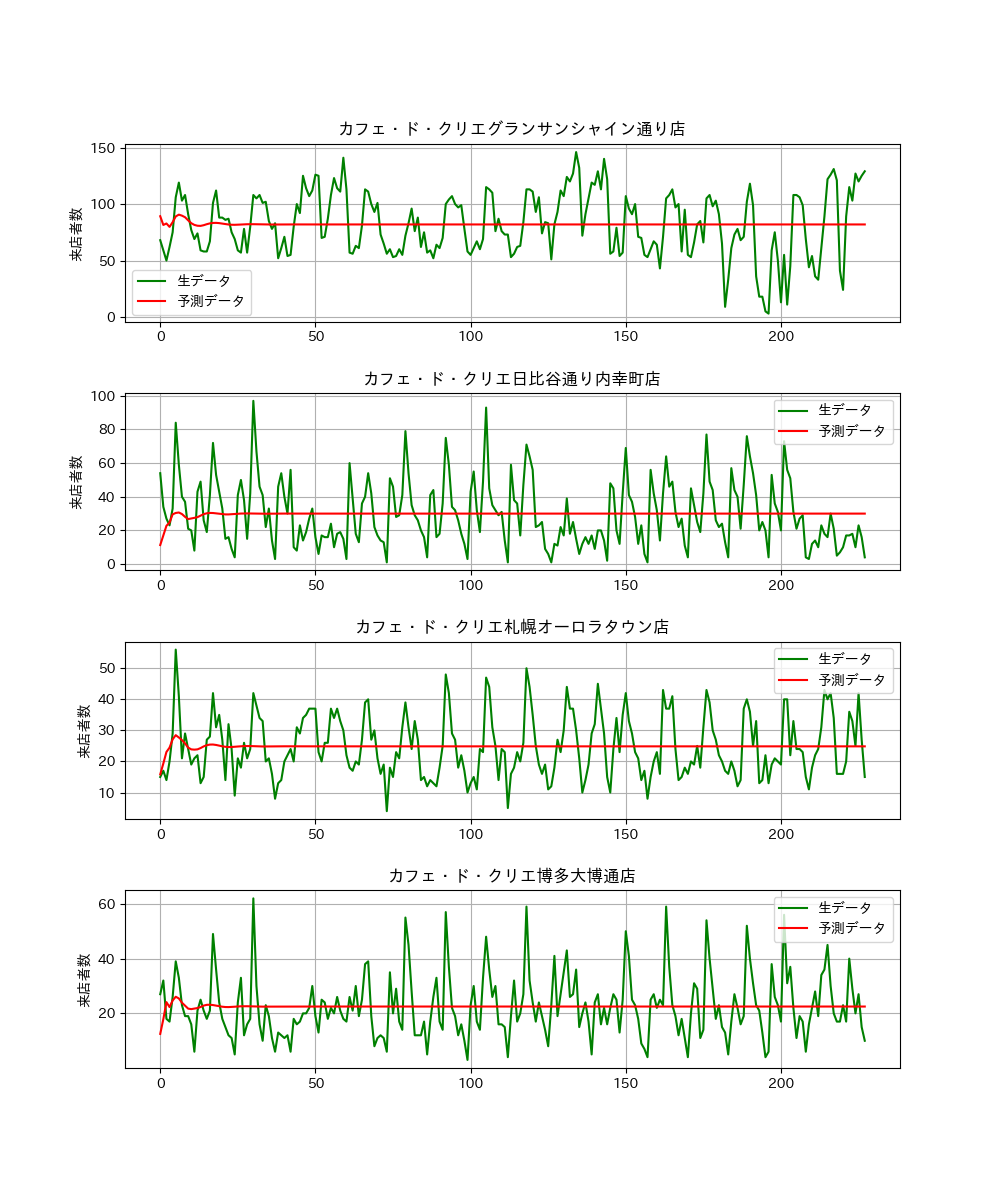

In [14]:
x_train, x_test = x_data[0:3600], x_data[3600:]
num = len(x_test)
mean = []
test_data = []
for idx in range(0, lag):
	test_data = test_data + x_test[lag - idx - 1]
for idx in range(lag, num):
	tmp = model.predict([test_data])
	mean.append(tmp[0])
	test_data = [*tmp[0], *test_data[0:-4]]

x_plot, mean = np.array(x_test), np.array(mean)
plt.figure(figsize=(10, 12))
plt.subplots_adjust(wspace=0.15,hspace=0.4)

plt.subplot(4,1,1)
plt.plot(x_plot[lag:, 0], "-", color="green", label="生データ")
plt.plot(mean[:, 0],      "-", color="red",   label="予測データ")
plt.title("カフェ・ド・クリエグランサンシャイン通り店")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()

plt.subplot(4,1,2)
plt.plot(x_plot[lag:, 1], "-", color="green", label="生データ")
plt.plot(mean[:, 1],      "-", color="red",   label="予測データ")
plt.title("カフェ・ド・クリエ日比谷通り内幸町店")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()

plt.subplot(4,1,3)
plt.plot(x_plot[lag:, 2], "-", color="green", label="生データ")
plt.plot(mean[:, 2],      "-", color="red",   label="予測データ")
plt.title("カフェ・ド・クリエ札幌オーロラタウン店")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()

plt.subplot(4,1,4)
plt.plot(x_plot[lag:, 3], "-", color="green", label="生データ")
plt.plot(mean[:, 3],      "-", color="red",   label="予測データ")
plt.title("カフェ・ド・クリエ博多大博通店")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()

model.stat_inf()

In [15]:
print("グレンジャー因果性テスト(p値 = 0.05)")
print("")

t = model.test_causality(causing=0, caused=1)
print("カフェ・ド・クリエグランサンシャイン通り店" + " → " + "カフェ・ド・クリエ日比谷通り内幸町店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

t = model.test_causality(causing=0, caused=2)
print("カフェ・ド・クリエグランサンシャイン通り店" + " → " + "カフェ・ド・クリエ札幌オーロラタウン店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

t = model.test_causality(causing=0, caused=3)
print("カフェ・ド・クリエグランサンシャイン通り店" + " → " + "カフェ・ド・クリエ博多大博通店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

t = model.test_causality(causing=1, caused=0)
print("カフェ・ド・クリエ日比谷通り内幸町店" + " → " + "カフェ・ド・クリエグランサンシャイン通り店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

t = model.test_causality(causing=1, caused=2)
print("カフェ・ド・クリエ日比谷通り内幸町店" + " → " + "カフェ・ド・クリエ札幌オーロラタウン店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

t = model.test_causality(causing=1, caused=3)
print("カフェ・ド・クリエ日比谷通り内幸町店" + " → " + "カフェ・ド・クリエ博多大博通店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

t = model.test_causality(causing=2, caused=0)
print("カフェ・ド・クリエ札幌オーロラタウン店" + " → " + "カフェ・ド・クリエグランサンシャイン通り店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

t = model.test_causality(causing=2, caused=1)
print("カフェ・ド・クリエ札幌オーロラタウン店" + " → " + "カフェ・ド・クリエ日比谷通り内幸町店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

t = model.test_causality(causing=2, caused=3)
print("カフェ・ド・クリエ札幌オーロラタウン店" + " → " + "カフェ・ド・クリエ博多大博通店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

t = model.test_causality(causing=3, caused=0)
print("カフェ・ド・クリエ博多大博通店" + " → " + "カフェ・ド・クリエグランサンシャイン通り店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

t = model.test_causality(causing=3, caused=1)
print("カフェ・ド・クリエ博多大博通店" + " → " + "カフェ・ド・クリエ日比谷通り内幸町店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

t = model.test_causality(causing=3, caused=2)
print("カフェ・ド・クリエ博多大博通店" + " → " + "カフェ・ド・クリエ札幌オーロラタウン店")
print("F検定量:", t[0], "  ", "p値:", t[1])
print("グレンジャー因果性有り" if t[1] < 0.05 else "グレンジャー因果性無し")
print("")

グレンジャー因果性テスト(p値 = 0.05)

カフェ・ド・クリエグランサンシャイン通り店 → カフェ・ド・クリエ日比谷通り内幸町店
F検定量: 4.635668874817753    p値: 0.3267623452673172
グレンジャー因果性無し

カフェ・ド・クリエグランサンシャイン通り店 → カフェ・ド・クリエ札幌オーロラタウン店
F検定量: 3.806783960336983    p値: 0.4327858360303505
グレンジャー因果性無し

カフェ・ド・クリエグランサンシャイン通り店 → カフェ・ド・クリエ博多大博通店
F検定量: 4.942986381802937    p値: 0.2931976350140899
グレンジャー因果性無し

カフェ・ド・クリエ日比谷通り内幸町店 → カフェ・ド・クリエグランサンシャイン通り店
F検定量: 23.130449004350112    p値: 0.00011924963797197117
グレンジャー因果性有り

カフェ・ド・クリエ日比谷通り内幸町店 → カフェ・ド・クリエ札幌オーロラタウン店
F検定量: 23.79208192653197    p値: 8.791671596746922e-05
グレンジャー因果性有り

カフェ・ド・クリエ日比谷通り内幸町店 → カフェ・ド・クリエ博多大博通店
F検定量: 27.3382277031235    p値: 1.698177807511382e-05
グレンジャー因果性有り

カフェ・ド・クリエ札幌オーロラタウン店 → カフェ・ド・クリエグランサンシャイン通り店
F検定量: 32.92138882516249    p値: 1.2395748607921363e-06
グレンジャー因果性有り

カフェ・ド・クリエ札幌オーロラタウン店 → カフェ・ド・クリエ日比谷通り内幸町店
F検定量: 22.141770062529794    p値: 0.00018780832295899267
グレンジャー因果性有り

カフェ・ド・クリエ札幌オーロラタウン店 → カフェ・ド・クリエ博多大博通店
F検定量: 29.800552794818884    p値: 5.373990020069395e-06
グレンジャー因果性有り

カフェ・ド・クリエ博多大博通

簡易対応表
y1: グランサンシャイン通り店
y2: 日比谷通り内幸町店
y3: 札幌オーロラタウン店
y4: 博多大博通店


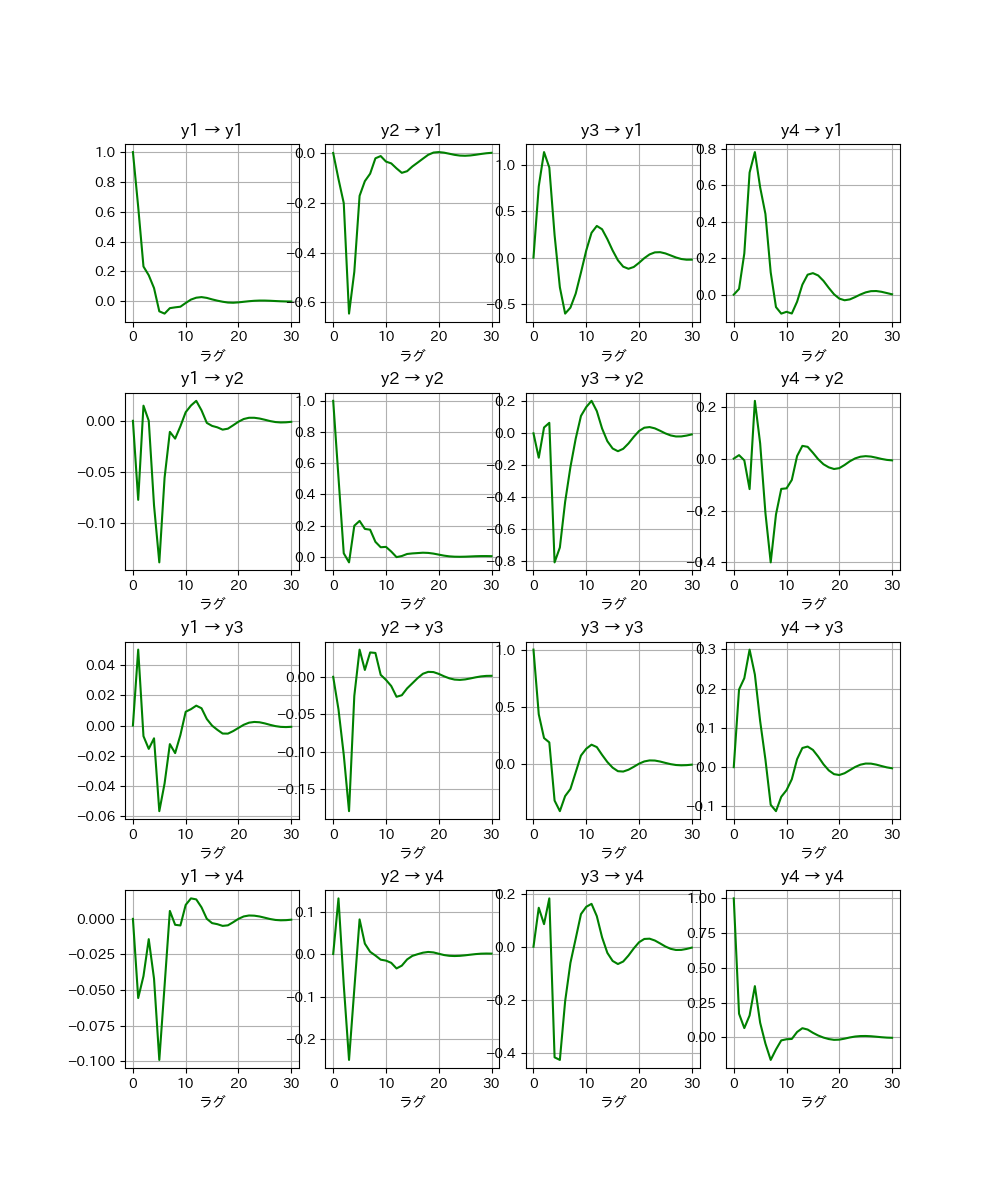

In [16]:
irf = model.irf(period=30, orth=False)

print("簡易対応表")
print("y1: グランサンシャイン通り店")
print("y2: 日比谷通り内幸町店")
print("y3: 札幌オーロラタウン店")
print("y4: 博多大博通店")

plt.figure(figsize=(10, 12))
plt.subplots_adjust(wspace=0.15,hspace=0.4)

plt.subplot(4,4,1)
plt.plot(irf[:, 0, 0], "-", color="green", label="生データ")
plt.title("y1 → y1")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,2)
plt.plot(irf[:, 0, 1], "-", color="green", label="生データ")
plt.title("y2 → y1")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,3)
plt.plot(irf[:, 0, 2], "-", color="green", label="生データ")
plt.title("y3 → y1")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,4)
plt.plot(irf[:, 0, 3], "-", color="green", label="生データ")
plt.title("y4 → y1")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,5)
plt.plot(irf[:, 1, 0], "-", color="green", label="生データ")
plt.title("y1 → y2")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,6)
plt.plot(irf[:, 1, 1], "-", color="green", label="生データ")
plt.title("y2 → y2")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,7)
plt.plot(irf[:, 1, 2], "-", color="green", label="生データ")
plt.title("y3 → y2")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,8)
plt.plot(irf[:, 1, 3], "-", color="green", label="生データ")
plt.title("y4 → y2")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,9)
plt.plot(irf[:, 2, 0], "-", color="green", label="生データ")
plt.title("y1 → y3")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,10)
plt.plot(irf[:, 2, 1], "-", color="green", label="生データ")
plt.title("y2 → y3")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,11)
plt.plot(irf[:, 2, 2], "-", color="green", label="生データ")
plt.title("y3 → y3")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,12)
plt.plot(irf[:, 2, 3], "-", color="green", label="生データ")
plt.title("y4 → y3")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,13)
plt.plot(irf[:, 3, 0], "-", color="green", label="生データ")
plt.title("y1 → y4")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,14)
plt.plot(irf[:, 3, 1], "-", color="green", label="生データ")
plt.title("y2 → y4")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,15)
plt.plot(irf[:, 3, 2], "-", color="green", label="生データ")
plt.title("y3 → y4")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,16)
plt.plot(irf[:, 3, 3], "-", color="green", label="生データ")
plt.title("y4 → y4")
plt.xlabel("ラグ")
plt.grid(True)




簡易対応表
y1: グランサンシャイン通り店
y2: 日比谷通り内幸町店
y3: 札幌オーロラタウン店
y4: 博多大博通店


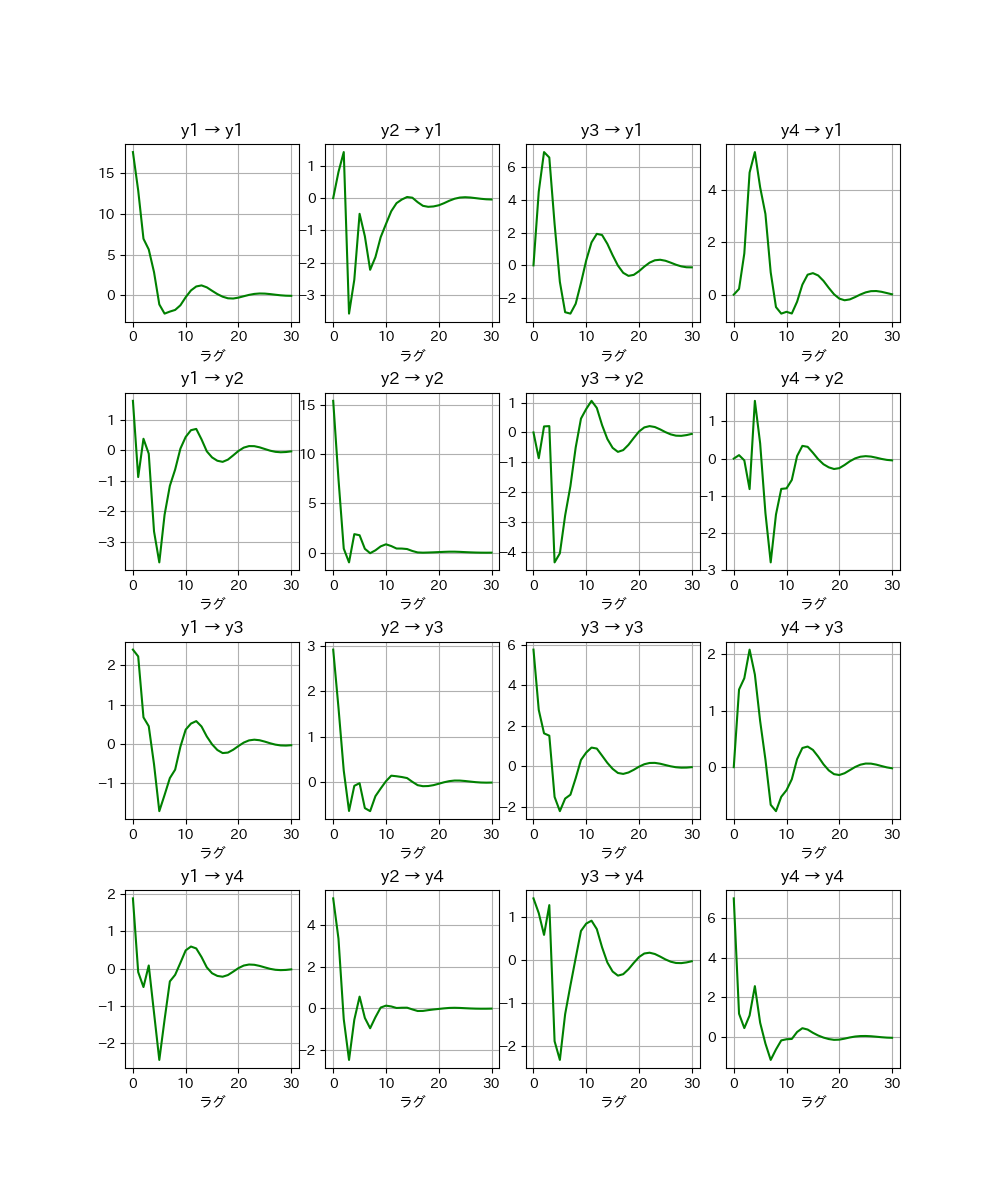

In [17]:
irf = model.irf(period=30, orth=True)

print("簡易対応表")
print("y1: グランサンシャイン通り店")
print("y2: 日比谷通り内幸町店")
print("y3: 札幌オーロラタウン店")
print("y4: 博多大博通店")

plt.figure(figsize=(10, 12))
plt.subplots_adjust(wspace=0.15,hspace=0.4)

plt.subplot(4,4,1)
plt.plot(irf[:, 0, 0], "-", color="green", label="生データ")
plt.title("y1 → y1")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,2)
plt.plot(irf[:, 0, 1], "-", color="green", label="生データ")
plt.title("y2 → y1")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,3)
plt.plot(irf[:, 0, 2], "-", color="green", label="生データ")
plt.title("y3 → y1")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,4)
plt.plot(irf[:, 0, 3], "-", color="green", label="生データ")
plt.title("y4 → y1")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,5)
plt.plot(irf[:, 1, 0], "-", color="green", label="生データ")
plt.title("y1 → y2")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,6)
plt.plot(irf[:, 1, 1], "-", color="green", label="生データ")
plt.title("y2 → y2")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,7)
plt.plot(irf[:, 1, 2], "-", color="green", label="生データ")
plt.title("y3 → y2")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,8)
plt.plot(irf[:, 1, 3], "-", color="green", label="生データ")
plt.title("y4 → y2")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,9)
plt.plot(irf[:, 2, 0], "-", color="green", label="生データ")
plt.title("y1 → y3")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,10)
plt.plot(irf[:, 2, 1], "-", color="green", label="生データ")
plt.title("y2 → y3")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,11)
plt.plot(irf[:, 2, 2], "-", color="green", label="生データ")
plt.title("y3 → y3")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,12)
plt.plot(irf[:, 2, 3], "-", color="green", label="生データ")
plt.title("y4 → y3")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,13)
plt.plot(irf[:, 3, 0], "-", color="green", label="生データ")
plt.title("y1 → y4")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,14)
plt.plot(irf[:, 3, 1], "-", color="green", label="生データ")
plt.title("y2 → y4")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,15)
plt.plot(irf[:, 3, 2], "-", color="green", label="生データ")
plt.title("y3 → y4")
plt.xlabel("ラグ")
plt.grid(True)

plt.subplot(4,4,16)
plt.plot(irf[:, 3, 3], "-", color="green", label="生データ")
plt.title("y4 → y4")
plt.xlabel("ラグ")
plt.grid(True)
plt.show()

簡易対応表
y1: グランサンシャイン通り店
y2: 日比谷通り内幸町店
y3: 札幌オーロラタウン店
y4: 博多大博通店


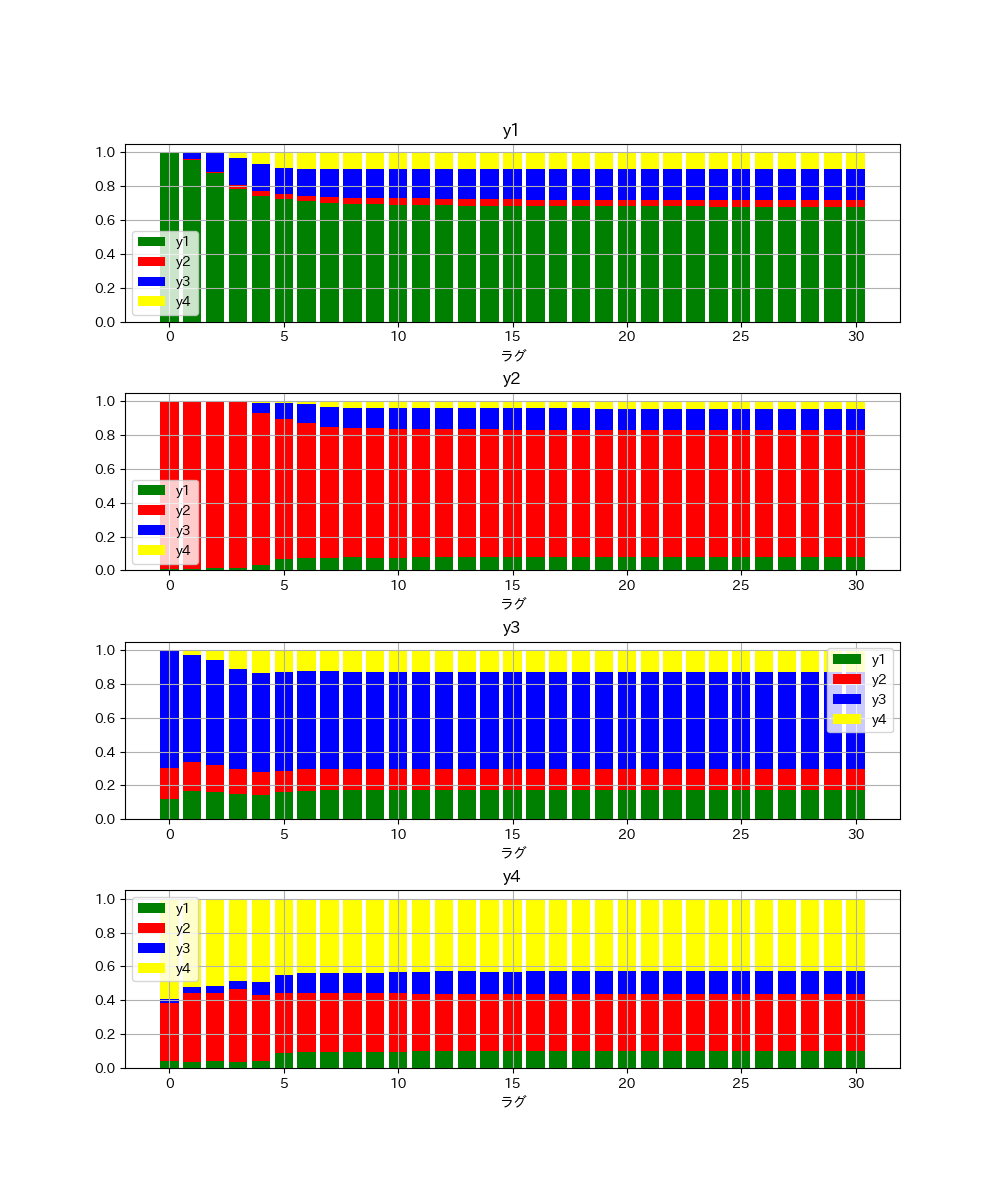

In [18]:
periods = 30
fevd = model.fevd(period=periods)
periods = len(fevd)

print("簡易対応表")
print("y1: グランサンシャイン通り店")
print("y2: 日比谷通り内幸町店")
print("y3: 札幌オーロラタウン店")
print("y4: 博多大博通店")

plt.figure(figsize=(10, 12))
plt.subplots_adjust(wspace=0.15,hspace=0.4)

plt.subplot(4,1,1)
ticks  = np.arange(periods)
lower  = np.zeros(periods)
height = fevd[:, 0, 0]
plt.bar(ticks, height, bottom=lower, color="green",  label="y1")

lower = lower + height
height = fevd[:, 0, 1]
plt.bar(ticks, height, bottom=lower, color="red",    label="y2")

lower = lower + height
height = fevd[:, 0, 2]
plt.bar(ticks, height, bottom=lower, color="blue",   label="y3")

lower = lower + height
height = fevd[:, 0, 3]
plt.bar(ticks, height, bottom=lower, color="yellow", label="y4")
plt.title("y1")
plt.xlabel("ラグ")
plt.grid(True)
plt.legend()

plt.subplot(4,1,2)
lower  = np.zeros(periods)
height = fevd[:, 1, 0]
plt.bar(ticks, height, bottom=lower, color="green",  label="y1")

lower = lower + height
height = fevd[:, 1, 1]
plt.bar(ticks, height, bottom=lower, color="red",    label="y2")

lower = lower + height
height = fevd[:, 1, 2]
plt.bar(ticks, height, bottom=lower, color="blue",   label="y3")

lower = lower + height
height = fevd[:, 1, 3]
plt.bar(ticks, height, bottom=lower, color="yellow", label="y4")
plt.title("y2")
plt.xlabel("ラグ")
plt.grid(True)
plt.legend()

plt.subplot(4,1,3)
lower  = np.zeros(periods)
height = fevd[:, 2, 0]
plt.bar(ticks, height, bottom=lower, color="green",  label="y1")

lower = lower + height
height = fevd[:, 2, 1]
plt.bar(ticks, height, bottom=lower, color="red",    label="y2")

lower = lower + height
height = fevd[:, 2, 2]
plt.bar(ticks, height, bottom=lower, color="blue",   label="y3")

lower = lower + height
height = fevd[:, 2, 3]
plt.bar(ticks, height, bottom=lower, color="yellow", label="y4")
plt.title("y3")
plt.xlabel("ラグ")
plt.grid(True)
plt.legend()

plt.subplot(4,1,4)
lower  = np.zeros(periods)
height = fevd[:, 3, 0]
plt.bar(ticks, height, bottom=lower, color="green",  label="y1")

lower = lower + height
height = fevd[:, 3, 1]
plt.bar(ticks, height, bottom=lower, color="red",    label="y2")

lower = lower + height
height = fevd[:, 3, 2]
plt.bar(ticks, height, bottom=lower, color="blue",   label="y3")

lower = lower + height
height = fevd[:, 3, 3]
plt.bar(ticks, height, bottom=lower, color="yellow", label="y4")
plt.title("y4")
plt.xlabel("ラグ")
plt.grid(True)
plt.legend()


In [19]:
irf = model.irf(period=1, orth=True)
print(irf.round(4))

[[[17.6243  0.      0.      0.    ]
  [ 1.6104 15.4438  0.      0.    ]
  [ 2.4039  2.9242  5.7753  0.    ]
  [ 1.8748  5.2905  1.4367  6.9697]]

 [[12.8975  0.8092  4.501   0.2197]
  [-0.882   7.4801 -0.8634  0.0934]
  [ 2.2301  1.6421  2.7902  1.3756]
  [-0.0957  3.3516  1.0943  1.1846]]]


In [20]:
X = np.zeros([10,10])
X[0:5, 0:5] = np.random.normal(0, 1, [5,5])
X = X + X.T
L,D = modified_cholesky(X)
print(L)
print(D)
print(np.abs(X - np.dot(L, np.dot(D, L.T))))
print(np.abs(X - np.dot(L, np.dot(D, L.T))) < 1e-10)

[[ 1.      0.      0.      0.      0.      0.      0.      0.      0.      0.    ]
 [-4.2341  1.      0.      0.      0.      0.      0.      0.      0.      0.    ]
 [-4.9473  3.8215  1.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 3.4857 -1.5101 -0.2977  1.      0.      0.      0.      0.      0.      0.    ]
 [ 0.5806 -0.8382 -0.1494 -1.4451  1.      0.      0.      0.      0.      0.    ]
 [ 0.     -0.      0.     -0.      0.      1.      0.      0.      0.      0.    ]
 [ 0.     -0.      0.     -0.      0.      0.      1.      0.      0.      0.    ]
 [ 0.     -0.      0.     -0.      0.      0.      0.      1.      0.      0.    ]
 [ 0.     -0.      0.     -0.      0.      0.      0.      0.      1.      0.    ]
 [ 0.     -0.      0.     -0.      0.      0.      0.      0.      0.      1.    ]]
[[ 0.3353  0.      0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.     -2.2069  0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 